In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
from utils import preprocess_copy, calculate_bearing, haversine

# 1. 读取并预处理训练数据
df = pd.read_csv("./data/train.csv")
df = preprocess_copy(df)

In [2]:
# 特征列表
features = [
    'distance_km',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'pickup_hour',
    'passenger_count',
    'vendor_id',
    'month',
    'day_of_week',
    'direction',
]

# 3. 准备训练数据 X 和 y
X = df[features]
y = df['trip_duration']
# 对目标变量做对数变换
y_log = np.log1p(y)

# 4. 读取并预处理测试数据 (确保和训练集一致)
df_test = pd.read_csv("./data/test.csv")


In [3]:
# --- 测试集预处理开始 ---
# 基础时间转换
df_test["pickup_datetime"] = pd.to_datetime(df_test["pickup_datetime"])

# 计算时间特征
df_test["month"] = df_test["pickup_datetime"].dt.month
df_test["day_of_week"] = df_test["pickup_datetime"].dt.dayofweek
df_test["pickup_hour"] = df_test["pickup_datetime"].dt.hour

# 计算地理特征
df_test["distance_km"] = haversine(
    df_test["pickup_longitude"], df_test["pickup_latitude"],
    df_test["dropoff_longitude"], df_test["dropoff_latitude"]
)
df_test["direction"] = calculate_bearing(
    df_test['pickup_latitude'], df_test['pickup_longitude'],
    df_test['dropoff_latitude'], df_test['dropoff_longitude']
)
# --- 测试集预处理结束 ---

X_test = df_test[features]

In [4]:
# 5. 定义 LightGBM 参数
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 100,
    'max_depth': -1,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'n_jobs': 4, 
    'seed': 42,
    'verbose': -1 # 减少日志输出
}

In [5]:
# 6. K-Fold 交叉验证与预测
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# 用于存储每一次折叠对测试集的预测结果
test_preds = []
# 用于存储每一次折叠的验证分数
val_scores = []

print(f"Starting {n_folds}-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_log)):
    print(f"\n--- Fold {fold+1} ---")
    
    # 切分数据
    X_train_fold, y_train_fold = X.iloc[train_idx], y_log.iloc[train_idx]
    X_val_fold, y_val_fold = X.iloc[val_idx], y_log.iloc[val_idx]
    
    # 构建 Dataset
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    # 训练模型
    model = lgb.train(
        params,
        train_data,
        num_boost_round=5000,
        valid_sets=[train_data, val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=500)
        ]
    )
    
    # 记录最佳验证分数
    best_score = model.best_score['valid_1']['rmse']
    val_scores.append(best_score)
    print(f"Fold {fold+1} Best RMSE: {best_score}")
    
    # 对测试集进行预测 (Log scale)
    # 注意：这里预测的是 log(duration + 1)
    pred_log = model.predict(X_test, num_iteration=model.best_iteration)
    
    # 将预测结果还原为真实时长 (exp - 1) 并存入列表
    test_preds.append(np.expm1(pred_log))


Starting 5-Fold Cross-Validation...

--- Fold 1 ---
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.37628	valid_1's rmse: 0.392813
[1000]	training's rmse: 0.361201	valid_1's rmse: 0.390488
[1500]	training's rmse: 0.351049	valid_1's rmse: 0.3897
Early stopping, best iteration is:
[1488]	training's rmse: 0.35126	valid_1's rmse: 0.389681
Fold 1 Best RMSE: 0.38968058587575893

--- Fold 2 ---
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.377737	valid_1's rmse: 0.387471
[1000]	training's rmse: 0.362993	valid_1's rmse: 0.3853
[1500]	training's rmse: 0.353085	valid_1's rmse: 0.384248
[2000]	training's rmse: 0.345378	valid_1's rmse: 0.383438
[2500]	training's rmse: 0.338838	valid_1's rmse: 0.382892
Early stopping, best iteration is:
[2586]	training's rmse: 0.337864	valid_1's rmse: 0.382861
Fold 2 Best RMSE: 0.38286066835809873

--- Fold 3 ---
Training until validation scores don't improve for 100 rounds
[500]	traini

In [6]:
# 7. 计算平均预测结果
# axis=0 表示对 5 个模型的预测值按列取平均
final_pred = np.mean(test_preds, axis=0)

print("\n" + "="*30)
print(f"Average CV RMSE: {np.mean(val_scores)}")
print("="*30)


Average CV RMSE: 0.38796574688683655


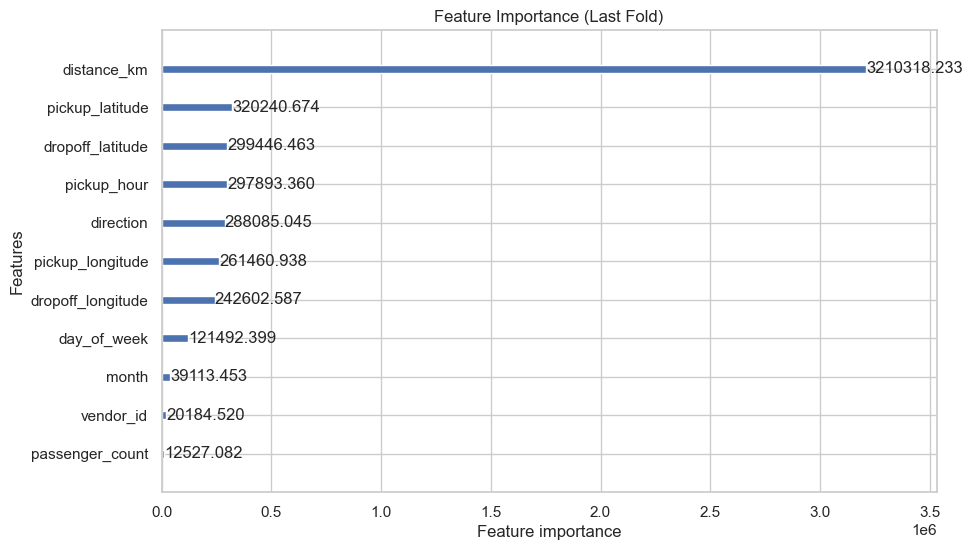

In [7]:
# 绘制最后一个模型的特征重要性
lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(10,6))
plt.title("Feature Importance (Last Fold)")
plt.show()

In [8]:
# 8. 生成提交文件
submission = pd.DataFrame({
    'id': df_test['id'],
    'trip_duration': final_pred
})
submission.to_csv('submission_kfold.csv', index=False)
print("Submission file saved to 'submission_kfold.csv'")

Submission file saved to 'submission_kfold.csv'
